In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
from statsmodels.tsa.stattools import adfuller


In [2]:
import yfinance as yf
import pandas as pd
nvda = yf.download("NVDA", start="2020-01-01", end="2025-01-01")
nvda_close = nvda['Close']
print(nvda_close.head())
nvda_close.to_csv("nvda_close_2020_2024.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Ticker          NVDA
Date                
2020-01-02  5.972161
2020-01-03  5.876571
2020-01-06  5.901216
2020-01-07  5.972659
2020-01-08  5.983860


# Basic Data Preprocessing

In [3]:
raw_df = pd.read_csv("nvda_close_2020_2024.csv")
raw_df.head()

,Date,NVDA
0,2020-01-02,5.972161
1,2020-01-03,5.876571
2,2020-01-06,5.901216
3,2020-01-07,5.972659
4,2020-01-08,5.983860


In [4]:
# Retain only the necessary columns and rows
Nvda_df_raw = raw_df.set_index('Date')[['NVDA']]
Nvda_df_raw.index = pd.to_datetime(Nvda_df_raw.index)
Nvda_df_raw.head()


,NVDA
Date,
2020-01-02,5.972161
2020-01-03,5.876571
2020-01-06,5.901216
2020-01-07,5.972659
2020-01-08,5.983860


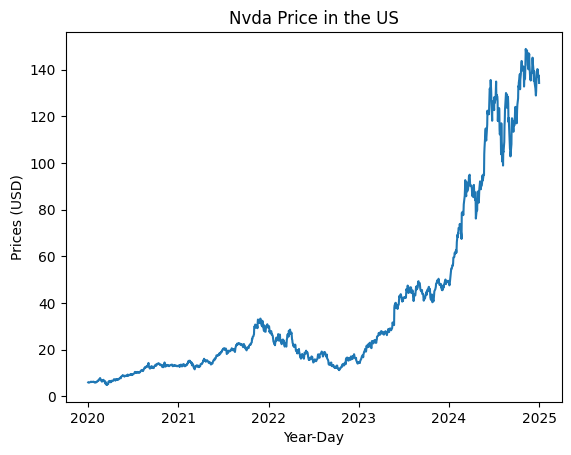

In [5]:
# Plot the time series
plt.plot(Nvda_df_raw)
plt.xlabel("Year-Day")
plt.ylabel("Prices (USD)")
plt.title("Nvda Price in the US")
plt.savefig("figures/price-ori.eps", format="eps")
plt.show()

In [6]:
# Information regarding the time series
Nvda_df_raw.describe()

,NVDA
count,1258.000000
mean,38.442412
std,38.230364
min,4.891977
25%,13.571985
50%,21.235978
75%,45.622280
max,148.856064


In [7]:

Nvda_df = Nvda_df_raw
Nvda_df["NVDA"] = np.log(Nvda_df_raw["NVDA"])
Nvda_df["log_return"]=Nvda_df["NVDA"].diff()
Nvda_df.describe()

,NVDA,log_return
count,1258.000000,1257.000000
mean,3.248828,0.002476
std,0.863385,0.033712
min,1.587597,-0.203979
25%,2.608008,-0.016125
50%,3.055697,0.003286
75%,3.820396,0.022061
max,5.002980,0.218088


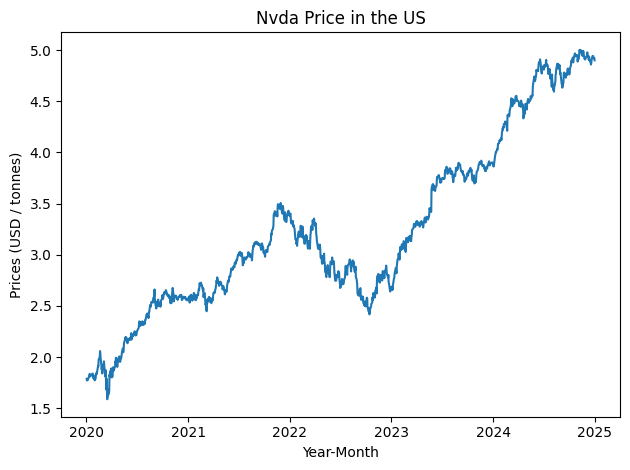

In [8]:
# Logged prices
plt.plot(Nvda_df["NVDA"])
plt.xlabel("Year-Month")
plt.ylabel("Prices (USD / tonnes)")
plt.title("Nvda Price in the US")
plt.tight_layout()
plt.savefig("figures/log-price.eps", format="eps")
plt.show()

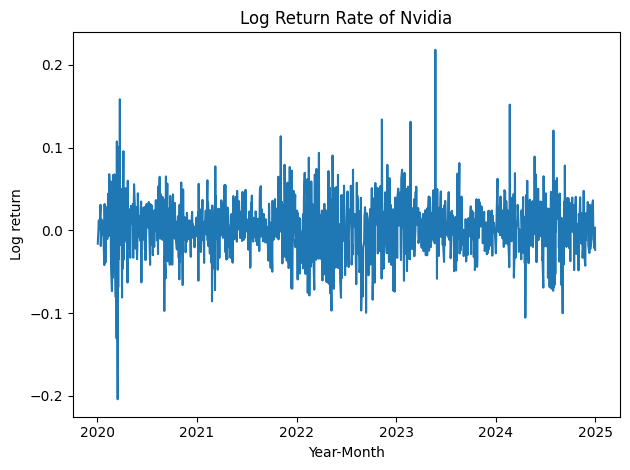

In [9]:
# Logged return
plt.plot(Nvda_df["log_return"])
plt.xlabel("Year-Month")
plt.ylabel("Log return")
plt.title("Log Return Rate of Nvidia")
plt.tight_layout()
plt.savefig("figures/log-return.eps", format="eps")
plt.show()

# Validation of the Time Series

In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox


returns = Nvda_df['log_return'].dropna()

# ADF
adf_result = adfuller(returns)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')  

# Ljung-Box
print(acorr_ljungbox(returns, lags=[1], return_df=True))
print(acorr_ljungbox(returns, lags=[12], return_df=True))


ADF Statistic: -10.886708207105352
p-value: 1.2546649341191304e-19
     lb_stat  lb_pvalue
1  10.900386   0.000961
      lb_stat  lb_pvalue
12  46.140308   0.000007


<Figure size 1200x500 with 0 Axes>

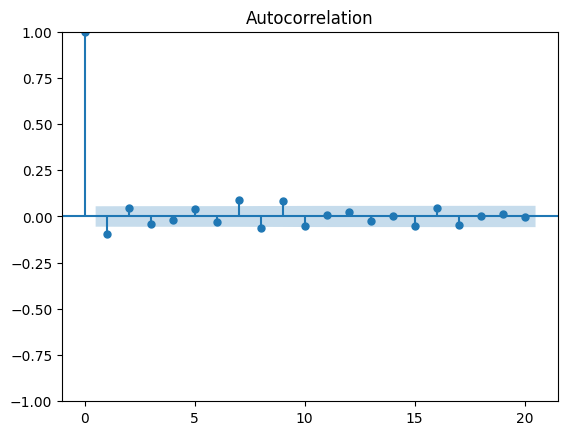

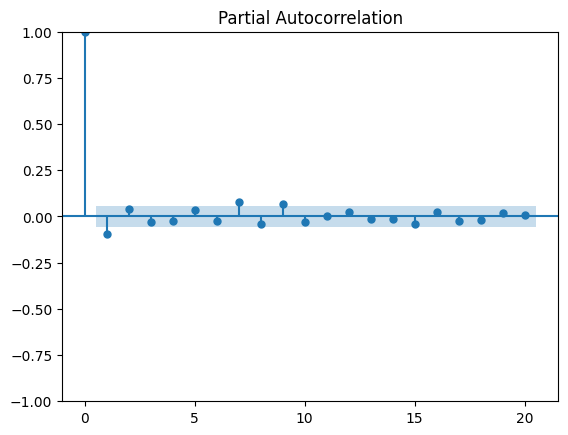

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(returns, lags=20)
plt.savefig("figures/log-return-acf.png")
plt.show()
plot_pacf(returns, lags=20)
plt.savefig("figures/log-return-pacf.png")
plt.show()

From the ADF test, we know that the series contained useful information and is currently not stable.

In [12]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    if p_value < 0.05:
        print("=> Reject H0: The series is NOT stationary.")
    else:
        print("=> Fail to reject H0: The series is likely stationary.")


kpss_test(returns, regression='ct')  

KPSS Statistic: 0.0967039191757487
p-value: 0.1
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
=> Fail to reject H0: The series is likely stationary.


C:\Users\yushe\AppData\Local\Temp\ipykernel_25388\3158123217.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


The ACF and PACF plots cut off at 1. Proceed with SARIMA model

# Model Fitting

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(returns, order=(1,0,1))  
arima_result = model.fit()
print(arima_result.summary())
residuals = arima_result.resid

c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1257
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2484.058
Date:                Thu, 15 May 2025   AIC                          -4960.116
Time:                        15:41:04   BIC                          -4939.570
Sample:                             0   HQIC                         -4952.394
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.737      0.006       0.001       0.004
ar.L1         -0.5644      0.166     -3.407      0.001      -0.889      -0.240
ma.L1          0.4761      0.176      2.703      0.0

In [14]:
from arch import arch_model
garch = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_result = garch.fit()
print(garch_result.summary())
print(garch_result.params)

c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 47388292.30002136
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17203352.754486118
Iteration:      3,   Func. Count:     28,   Neg. LLF: 598923.3524564015
Iteration:      4,   Func. Count:     35,   Neg. LLF: -2460.620444374993
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1241320.4838053174
Iteration:      6,   Func. Count:     47,   Neg. LLF: 324932.1295359389
Iteration:      7,   Func. Count:     58,   Neg. LLF: 97353.20866830702
Iteration:      8,   Func. Count:     68,   Neg. LLF: -2534.359501883508
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2534.3595016001464
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squar

Alpha1+Beta1 close to 1

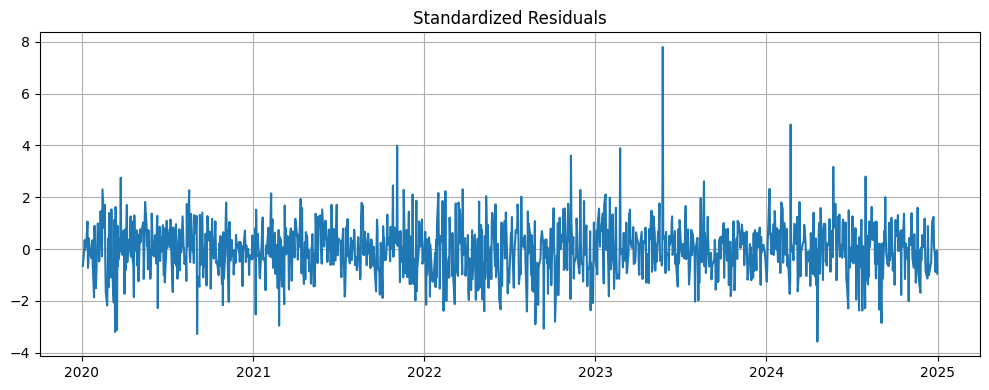

In [15]:
residuals = garch_result.resid / garch_result.conditional_volatility

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Standardized Residuals")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/z-score-garch.eps", format="eps")
plt.show()


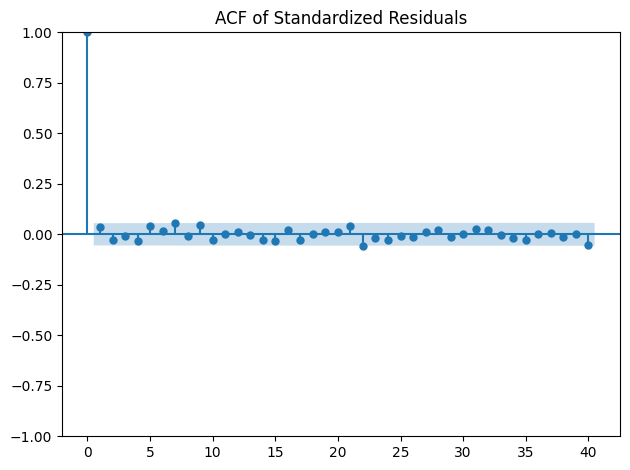

In [16]:
from statsmodels.graphics.tsaplots import plot_acf       

plot_acf(residuals, lags=40)
plt.title("ACF of Standardized Residuals")
plt.tight_layout()
plt.savefig("figures/acf-std-res.png")
plt.show()


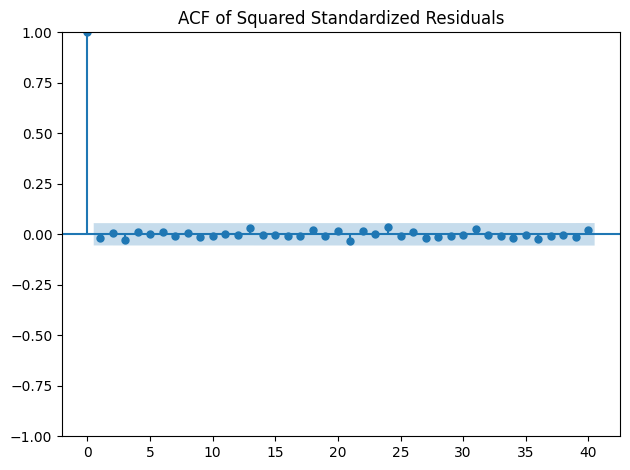

In [17]:
plot_acf(residuals**2, lags=40)
plt.title("ACF of Squared Standardized Residuals")
plt.tight_layout()
plt.savefig("figures/ACF-square-std-res.png")
plt.show()


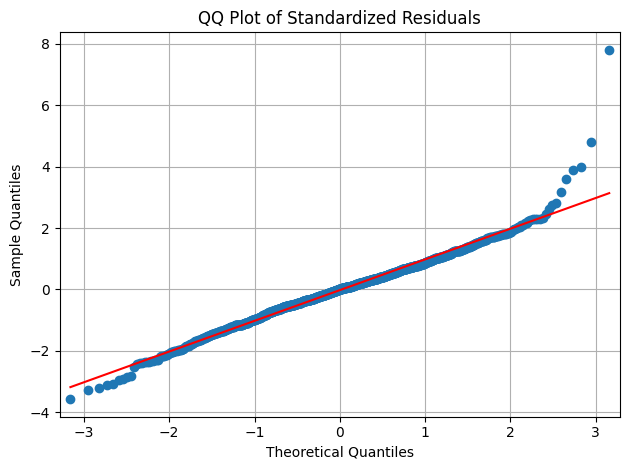

In [18]:
import scipy.stats as stats
import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Standardized Residuals')
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/qq-plot.png")
plt.show()


# Model Forcasting

c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\yushe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


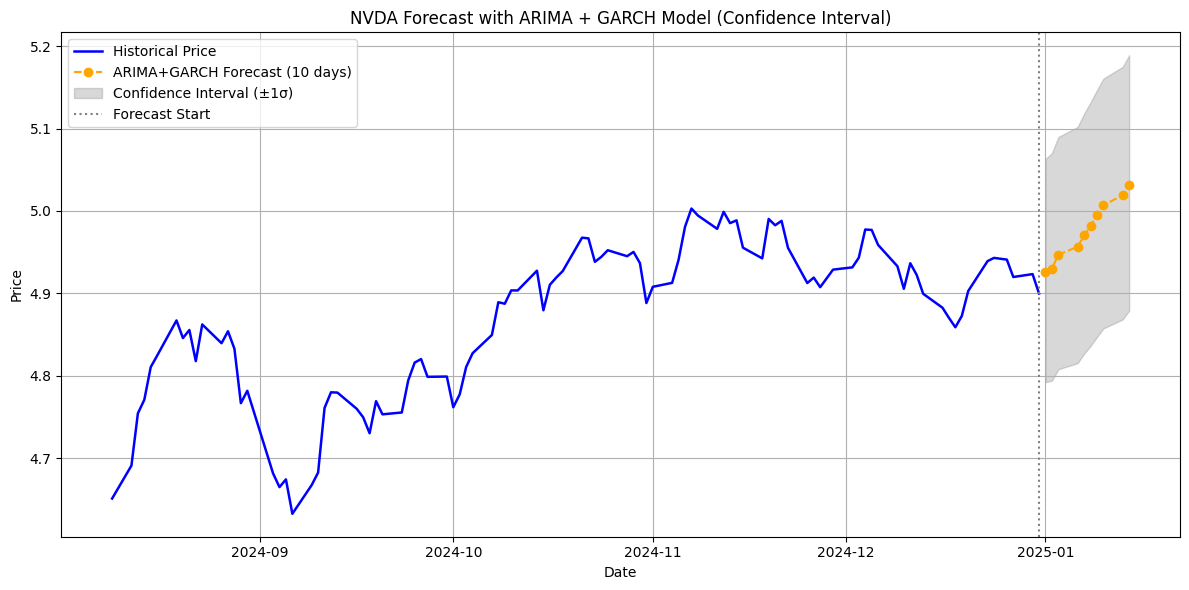

In [19]:
# forcasting 10 days return
forecast_horizon = 10
arima_forecast = arima_result.get_forecast(steps=forecast_horizon)
predicted_mean_return = arima_forecast.predicted_mean.values
garch_forecast = garch_result.forecast(horizon=forecast_horizon)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

last_price = Nvda_df['NVDA'].iloc[-1]
predicted_price = last_price * np.exp(np.cumsum(predicted_mean_return))

# Excluding the weekend
last_date = Nvda_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
upper_bound = predicted_price * np.exp(predicted_volatility)
lower_bound = predicted_price * np.exp(-predicted_volatility)
upper_series = pd.Series(upper_bound, index=future_dates)
lower_series = pd.Series(lower_bound, index=future_dates)
# Historical price
past_prices = Nvda_df['NVDA'].iloc[-100:]
# Forcast price
forecast_series = pd.Series(predicted_price, index=future_dates)

plt.figure(figsize=(12, 6))
plt.plot(past_prices, label='Historical Price', color='blue', linewidth=1.8)
plt.plot(forecast_series, label='ARIMA+GARCH Forecast (10 days)', linestyle='--', marker='o', color='orange')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval (±1σ)')
plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title('NVDA Forecast with ARIMA + GARCH Model (Confidence Interval)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/nvda-forecast.eps", format="eps")
plt.show()

In [20]:
np.exp(forecast_series)

2025-01-01    137.811272
2025-01-02    138.415171
2025-01-03    140.738418
2025-01-06    142.117350
2025-01-07    144.077619
2025-01-08    145.745911
2025-01-09    147.623064
2025-01-10    149.422896
2025-01-13    151.310045
2025-01-14    153.190937
Freq: B, dtype: float64